In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import pymc3 as pm
import pandas as pd
import arviz

# Taxonomy of Ireland
I've stumbled upon a dataset of animal sightings in the county of Cork, Ireland. Let's see if we can use it for some modeling fun. We want to go out in the nature in Ireland and spot some animals, at least one. *What's the probability that I spot at least one animal?* Taking the historical average of the number of sightings in Cork we get 2.3. Can we reproduce that result with a Bayesian model?

We have 586 observations in the dataset spanning the last few years. The highest number of observations in a single day has been 16 and the lowest 1. In the plot below, we see the histogram of the observation counts. As the name suggest we're looking at the number of events occuring in an interval of time. Such variable is usually thought to be [Poisson](https://en.wikipedia.org/wiki/Poisson_distribution) distributed. Let's look at the histogram of the counts or number of sightings.

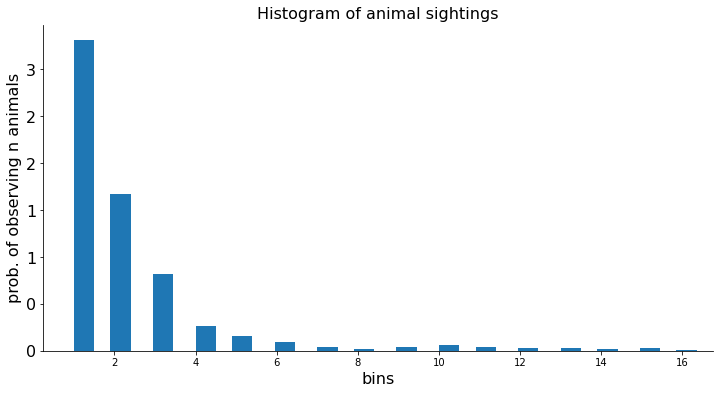

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.hist(obs_counts.values, bins=100, density=True, width=0.5)
plt.title("Histogram of animal sightings", fontsize=16)
plt.xlabel("bins", fontsize=16)
plt.ylabel("prob. of observing n animals", fontsize=16)
ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=16)
sns.despine()
plt.show()

The number of sightings does look like it could be Poisson distributed. But we'll make things a bit more spicy.

## PyMC Model
To model counts in an interval of time we could simply use a Poisson distribution, but to be fancy let's try with a [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution). It's a continuous distribution unlike Poisson but it can be adapted to look like a Poisson with the right parameters, let's see if MCMC can do the magic. Later on we'll compare the results with a Poisson likelihood model.

When specifying the PyMC3 model notice the argument `observed` in the last row. It tells PyMC that we're defining the likelihood and the parameters of that distribution are not estimated by the sampler but given by the data

In [ ]:
with pm.Model() as model:
    alpha = pm.HalfNormal('alpha', sigma=10)
    beta = pm.HalfNormal('beta', sigma=10)    
    r = pm.Gamma('obs', alpha=alpha, beta=beta, observed=obs_counts.values)

$$
\begin{align} 
\alpha \;\sim\; & \text{HalfNormal}(\sigma=10.0)\\
\beta \;\sim\; & \text{HalfNormal}(\sigma=10.0)\\
&\text{for}\;\text{i}=0,1,...\\
\text{obs}_i \;\sim\; & \text{Gamma}(\mathit{alpha}=\alpha,~\mathit{beta}=\beta)
\end{align} 
$$

Sample from the posterior with the NUTS sampler

In [14]:
with model:      
    trace = pm.sample(draws=10000, chains=2, tune=4000, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 14000/14000 [00:13<00:00, 1065.88it/s]
The number of effective samples is smaller than 25% for some parameters.


There are no *divergences*. If your model is complex or if you mix continuous and discrete densities you may get some divergences. If have many, it would mean that the result of the estimation of the parameters could be biased. The step size in the sampler is automatically calculated and it's best not to set it manually. A way to fix that is to reparametrize but it's not always easy and sometimes not an improvement. 

The sampler informes us that the number effective samples is low which is not good for us. The MC samples are rather correlated but the standard error (see below) of the parameters estimates is not large so we'll move on.

In [ ]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,1.925,0.105,1.735,2.129,0.002,0.001,4063.0,4063.0,4057.0,5344.0,1.0
beta,0.837,0.052,0.740,0.935,0.001,0.001,4100.0,4100.0,4093.0,5547.0,1.0


A few words on the table above:
1. **ESS** or effective sample size, is the number samples that can be considered to be necessary if they were sampled independently. In other words, you can think that 10k Markov chain samples could be "substituted" by 5k independent samples. We would like to have MC samples with low correlation. If the correlation between the MC samples is high, it starts diminishes the effective samples untill the ESS becomes zero.
2. **$\hat{r}$** (r_hat) is the Gelman and Rubin statistics. It is common to assume that a value larger than 1.1 indicates a problem in the convergence of the chain. We aim at having a value close to 1.
3. **hpd**, highest posterior density interval, it's the interval that contains the statistics (mean in our case) with a particular probability (3% - 97%). Note that confidence intervals cannot be interpreted in this way.

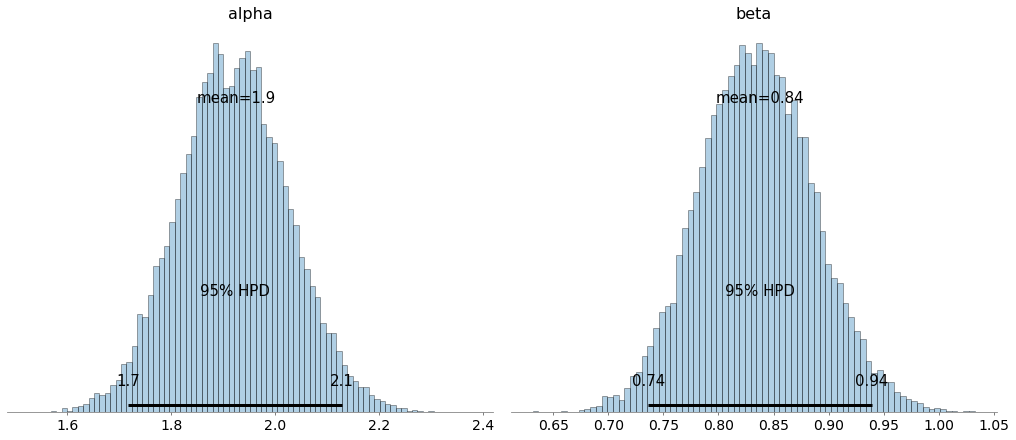

In [ ]:
pm.plot_posterior(trace, credible_interval=0.95, kind='hist', edgecolor='k', figsize=(14, 6));

The credible intervals are small which is good.

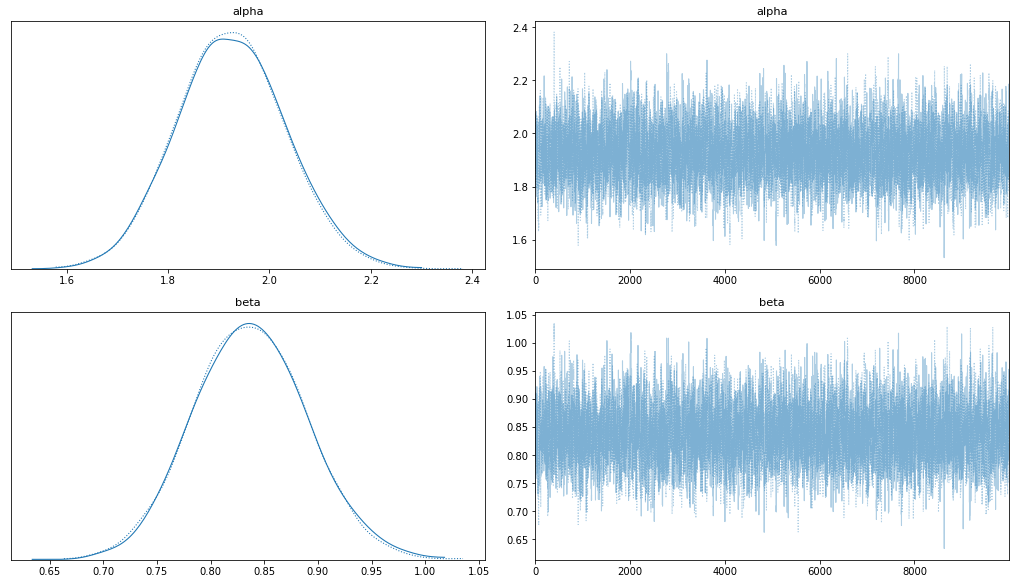

In [ ]:
pm.traceplot(trace, figsize=(14, 8));

Everything looks fine in the traces, no sticky points.


## Sanity checks, sampling the posterior
I want to go out in the nature and spot animals, at least one. *How many animals do I expect to see if I go out in the nature in a given day?*

On average 2.3. How do we get this result?
Now that we have a model we can sample it many times, simulating many different observations just like the dataset, then we average them out. Each sample that we get from our model is like a reproduction of the obseved reality that incorporates the uncertainty (or variation) in the model parameters *alpha* and *beta*. The uncertainty is taken into account by marginalizing (integrating) over the parameters to get the [*posterior predictive distribution*](https://en.wikipedia.org/wiki/Posterior_predictive_distribution).

Let's take 20k samples from the trace. For each sample (row of `post_samples`) we have 586 observations (columns of `post_samples`) from the Gamma distribution, the same number as in the original dataset.

In [32]:
post_samples = pm.sample_posterior_predictive(trace, 20000, model)
post_samples['obs'].shape

100%|██████████| 20000/20000 [00:10<00:00, 1840.33it/s]


(20000, 586)

What are those possible samples looking like? We know that each row of `post_samples` is a sample from the posterior predictive. Each row should look like our original data, otherwise our model is not capable of representing the original data. Let's plot a few samples.

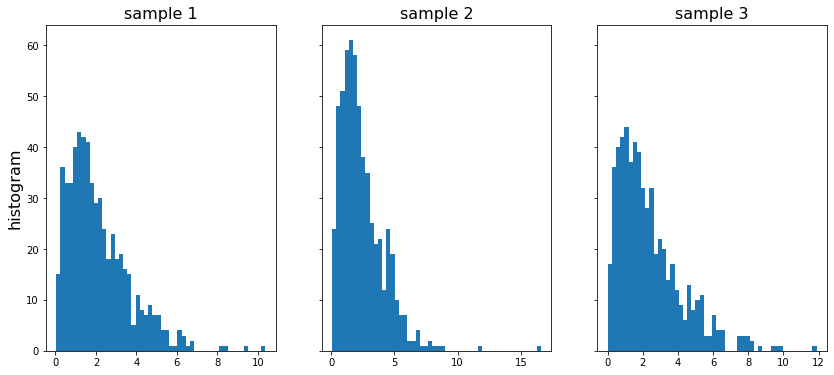

In [ ]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(14, 6))
ax[0].hist(post_samples['obs'][1, :], bins=50);
ax[1].hist(post_samples['obs'][10, :], bins=50);
ax[2].hist(post_samples['obs'][1000, :], bins=50);
ax[0].set_title("sample 1", fontsize=16);
ax[1].set_title("sample 2", fontsize=16);
ax[2].set_title("sample 3", fontsize=16);
ax[0].set_ylabel("histogram", fontsize=16);

They almost look like the original. Note that they really look  more like an histogram of a Gamma distribution as we have specified. We'll check later if there is a difference with a simpler Poisson model.

We are almost ready to answer the question at the beginning of the section. Consider the histograms above. One sample may tell us that on average we can spot 2.01 animals, another sample tells us that on average we can spot 2.63 animals. As we mentioned the variation is given by the uncertainty in the model parameters. The plot in blue below is the histogram of these averages. The average of the averages is the number we are looking for and it's plotted with a black line.

In [ ]:
means = post_samples['obs'].mean(axis=1)
means.shape

(20000,)

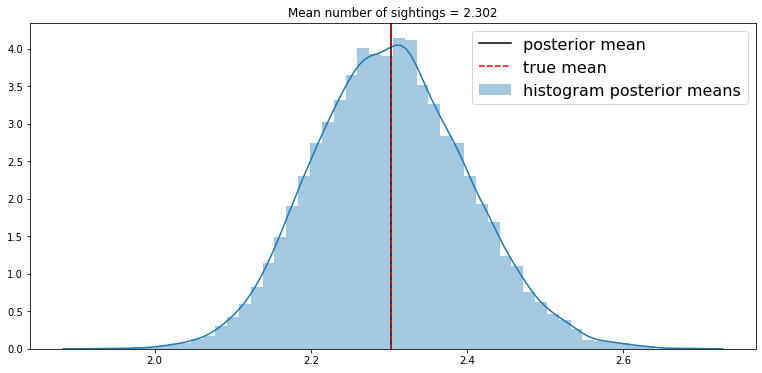

In [ ]:
plt.figure(figsize=(13, 6));
sns.distplot(means, label="histogram posterior means")
plt.axvline(post_samples['obs'].mean(), color="k", label="posterior mean")
plt.axvline(obs_counts.mean(), color='red', linestyle='dashed', label="true mean")
plt.title("Mean number of sightings = {:1.3f}".format(post_samples['obs'].mean()))
plt.legend(fontsize=16);

The mean of the real observations (dashed green line) is very close to the mean of the samples from the posterior (black line). *The mean number of animals we can spot by going in the nature in a given day is around 2.303*. From the dataset we get an average of 2.302.

## Try with a Poisson

In [ ]:
with pm.Model() as model:
  r = pm.HalfNormal('rate', sigma=10)        
  obs = pm.Poisson('obs', mu=r, observed=obs_counts.values)

In [ ]:
with model:
  trace = pm.sample(draws=10000, chains=2, tune=4000, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rate]
Sampling chain 1, 0 divergences: 100%|██████████| 14000/14000 [00:06<00:00, 2126.01it/s]


In [ ]:
pm.summary(trace)

In [ ]:
post_samples = pm.sample_posterior_predictive(trace, 20000, model)

100%|██████████| 20000/20000 [00:11<00:00, 1802.73it/s]


In [ ]:
post_samples['obs'].mean()

2.3041518771331058

Unsurprisingly it's almost exactly the same number we got with the Gamma.